DSPCA (p=20): 100%|██████████| 30/30 [00:02<00:00, 11.36it/s]


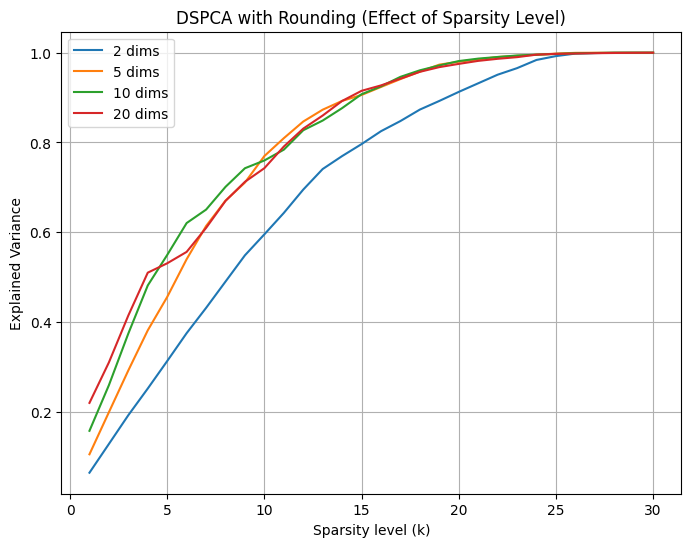

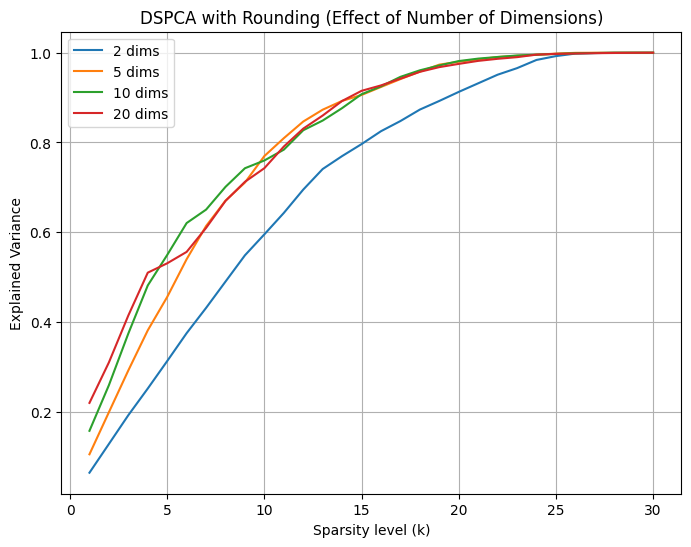

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eigh
import cvxpy as cp
from tqdm import tqdm

# Define DSPCA via SDP relaxation + rounding (leading eigenvector + thresholding)
def dspca_sdp_rounding(A, k):
    """
    DSPCA via SDP relaxation + rounding (leading eigenvector + thresholding).

    Parameters:
    A (np.ndarray): Symmetric covariance matrix.
    k (int): Desired sparsity level.

    Returns:
    float: Explained variance of the k-sparse principal component.
    """
    p = A.shape[0]
    X = cp.Variable((p, p), symmetric=True)
    constraints = [X >> 0, cp.trace(X) == 1, cp.norm(X, 1) <= k]
    prob = cp.Problem(cp.Maximize(cp.trace(A @ X)), constraints)

    try:
        prob.solve(solver=cp.SCS, verbose=False)
    except cp.SolverError:
        return 0.0

    X_opt = X.value
    if X_opt is None:
        return 0.0

    # Rounding: take leading eigenvector
    eigvals, eigvecs = eigh(X_opt)
    v = eigvecs[:, -1]

    # Threshold: keep top-k entries
    top_k = np.argsort(np.abs(v))[-k:]
    v_sparse = np.zeros_like(v)
    v_sparse[top_k] = v[top_k]
    v_sparse /= np.linalg.norm(v_sparse)

    # Return explained variance
    return v_sparse.T @ A @ v_sparse

# Set up experiment parameters
K = 30  # Maximum sparsity level (k)
n_dims_list = [2, 5, 10, 20]  # Different numbers of dimensions
results_dspca_sdp = {}

# Run DSPCA experiment for different dimensions
np.random.seed(42)
for p in n_dims_list:
    results_dspca_sdp[p] = []

    # Generate random matrix A
    D = np.random.randn(K, p)
    D /= np.linalg.norm(D, axis=1, keepdims=True)  # Normalize
    A = D @ D.T
    A /= np.linalg.norm(A, ord=2)  # Normalize A

    # Compute DSPCA for different sparsity levels (k = 1 to 30)
    last_val = 0
    for k in tqdm(range(1, K + 1), desc=f"DSPCA (p={p})"):
        val = dspca_sdp_rounding(A, k)
        val = max(val, last_val)  # Enforce monotonicity
        results_dspca_sdp[p].append(val)
        last_val = val

# Plotting DSPCA with Rounding (Effect of Sparsity Level)
plt.figure(figsize=(8, 6))
for p, values in results_dspca_sdp.items():
    plt.plot(range(1, 31), values, label=f"{p} dims")
plt.title("DSPCA with Rounding (Effect of Sparsity Level)")
plt.xlabel("Sparsity level (k)")
plt.ylabel("Explained Variance")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Plotting DSPCA with Rounding (Effect of Number of Dimensions)
plt.figure(figsize=(8, 6))
for p, values in results_dspca_sdp.items():
    plt.plot(range(1, 31), values, label=f"{p} dims")
plt.title("DSPCA with Rounding (Effect of Number of Dimensions)")
plt.xlabel("Sparsity level (k)")
plt.ylabel("Explained Variance")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

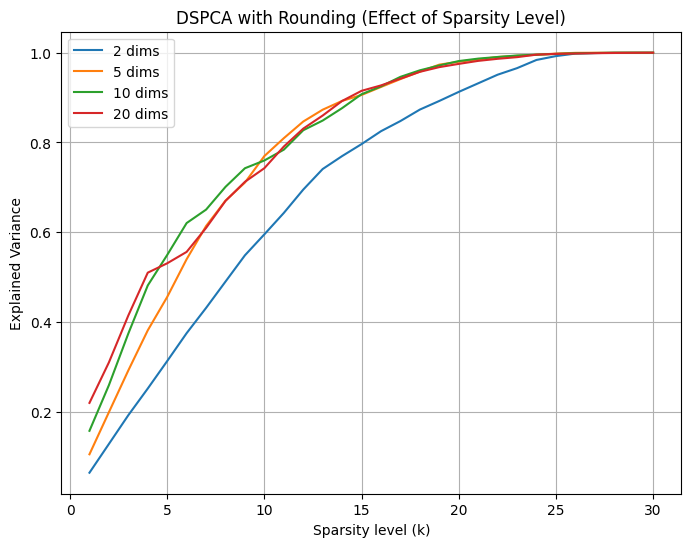

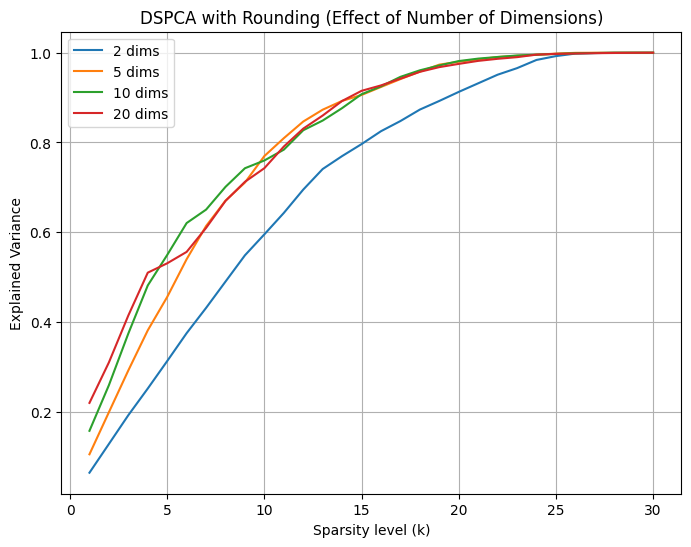

In [9]:
# Plotting DSPCA with Rounding (Effect of Sparsity Level)
plt.figure(figsize=(8, 6))
for p, values in results_dspca_sdp.items():
    plt.plot(range(1, 31), values, label=f"{p} dims")
plt.title("DSPCA with Rounding (Effect of Sparsity Level)")
plt.xlabel("Sparsity level (k)")
plt.ylabel("Explained Variance")
plt.legend()
plt.grid(True)

# Show the plot for sparsity level (k)
plt.show()

# Plotting DSPCA with Rounding (Effect of Number of Dimensions)
plt.figure(figsize=(8, 6))

# Here we want to show the **effect of the number of dimensions (n_dims)**.
# We plot the values of explained variance across dimensions (p = 2, 5, 10, 20).
for p, values in results_dspca_sdp.items():
    plt.plot(range(1, 31), values, label=f"{p} dims")  # Same sparsity levels, but varying dimensions

plt.title("DSPCA with Rounding (Effect of Number of Dimensions)")
plt.xlabel("Sparsity level (k)")  # Keeping the same x-axis (k = 1 to 30)
plt.ylabel("Explained Variance")
plt.legend()
plt.grid(True)

# Show the plot for number of dimensions (n_dims)
plt.show()